In [2]:

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:

# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)


32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
block_size = 3
def build_dataset(words):
    X, Y = [] , [] 
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] +[ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape , Y.shape)
    return X , Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr , Ytr = build_dataset(words[:n1])
Xte , Yte = build_dataset(words[n1:n2])
Xdev , Ydev = build_dataset(words[n2:])



        

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
n_embd = 10
n_hidden = 200 #neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size , n_embd), generator=g)
W1 = torch.randn((n_embd*block_size , n_hidden), generator=g)*(5/3)/(n_embd*block_size**0.5)
b1 = torch.randn((n_hidden) , generator=g) 
W2 = torch.randn((n_hidden , vocab_size) , generator= g) * 0.01
b2 = torch.randn((vocab_size) , generator=g) * 0

bngains = torch.ones((1 , n_hidden))
bnbais = torch.zeros((1 , n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C , W1 ,W2, b2 , bnbais , bngains]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12097


In [8]:
max_step = 200000
batch_size = 32
lossi = []
for i in range(max_step):
    #mini batch construct 
    ix = torch.randint( 0 , Xtr.shape[0]  , (batch_size ,) , generator=g)
    Xb , Yb = Xtr[ix] , Ytr[ix] #batch X ,Y
    #forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0] , -1)

    
    
    hpreact = emb_cat @ W1 + b1
    bnmeani = hpreact.mean(0 , keepdim=True)
    bnstdi = hpreact.std(0 , keepdim=True)
    hpreact = bngains * (hpreact - bnmeani)/bnstdi + bnbais
    
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    h = torch.tanh(hpreact)
    logits = h@W2 + b2
    loss = F.cross_entropy(logits , Yb)
    #backward pass
    for p in parameters:
        p.grad = None   
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    #track stats 
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d} / {max_step:7d} : {loss.item() :.4f}')
        
    lossi.append(loss.log10().item())
    
        

      0 /  200000 : 3.3147
  10000 /  200000 : 2.0977
  20000 /  200000 : 2.3415
  30000 /  200000 : 2.3992
  40000 /  200000 : 2.0276
  50000 /  200000 : 2.3060
  60000 /  200000 : 2.4402
  70000 /  200000 : 2.0833
  80000 /  200000 : 2.3971
  90000 /  200000 : 2.1310
 100000 /  200000 : 1.7951
 110000 /  200000 : 2.4099
 120000 /  200000 : 1.9640
 130000 /  200000 : 2.3886
 140000 /  200000 : 2.3378
 150000 /  200000 : 2.2366
 160000 /  200000 : 1.8501
 170000 /  200000 : 1.8672
 180000 /  200000 : 2.0711
 190000 /  200000 : 1.8476


In [9]:
#checking initial loss after initialisation

# loss = F.cross_entropy(logits, Yb)
print("Initial Loss:", loss.item())




Initial Loss: 2.2386913299560547


Text(0.5, 1.0, 'White = Dead Neurons')

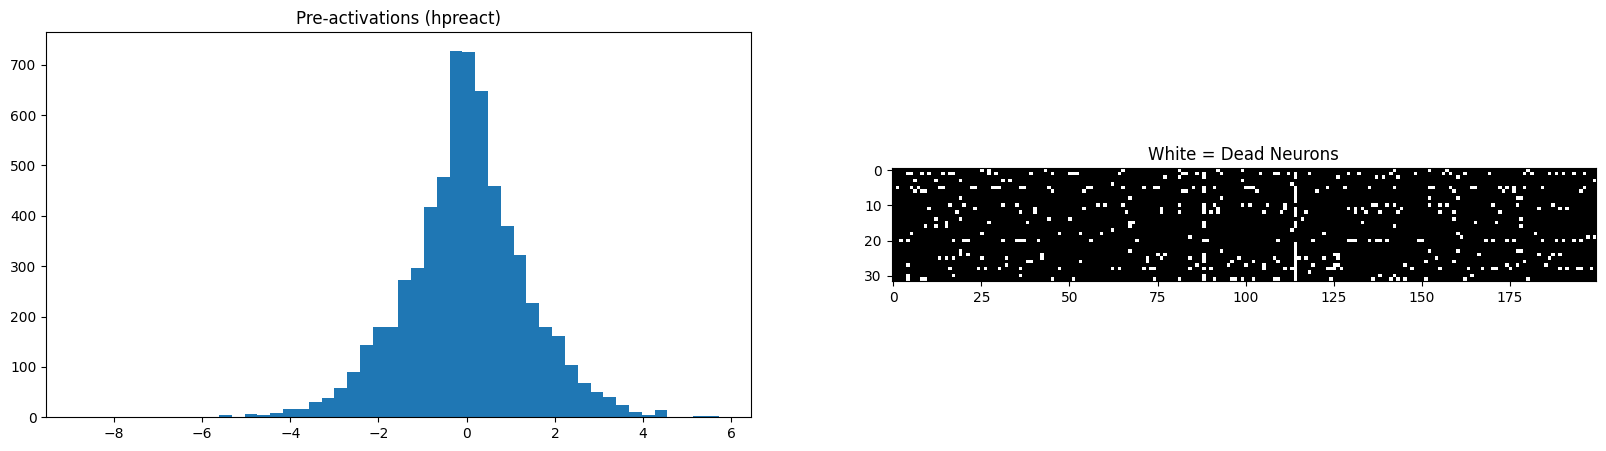

In [10]:
plt.figure(figsize=(20, 5))

# Plot 1: Histogram of Pre-activations (Before Tanh)
# We want these to be roughly between -1 and 1.
# If they are -5 or +5, Tanh will saturate.
plt.subplot(1, 2, 1)
plt.hist(hpreact.view(-1).tolist(), 50)
plt.title('Pre-activations (hpreact)')

# Plot 2: Heatmap of Tanh Saturation
# Black = Active (Good learning)
# White = Saturated at -1 or 1 (Gradient is dead)
plt.subplot(1, 2, 2)
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title('White = Dead Neurons')

(array([  1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          4.,   1.,   6.,   5.,   8.,  17.,  16.,  31.,  39.,  59.,  90.,
        143., 180., 180., 273., 296., 418., 477., 728., 726., 648., 459.,
        380., 323., 227., 180., 162., 104.,  68.,  50.,  41.,  24.,  10.,
          4.,  15.,   0.,   1.,   3.,   2.]),
 array([-8.81065941, -8.5202072 , -8.229755  , -7.9393028 , -7.64885059,
        -7.35839839, -7.06794619, -6.77749398, -6.48704178, -6.19658957,
        -5.90613737, -5.61568517, -5.32523296, -5.03478076, -4.74432856,
        -4.45387635, -4.16342415, -3.87297194, -3.58251974, -3.29206754,
        -3.00161533, -2.71116313, -2.42071093, -2.13025872, -1.83980652,
        -1.54935431, -1.25890211, -0.96844991, -0.6779977 , -0.3875455 ,
        -0.0970933 ,  0.19335891,  0.48381111,  0.77426332,  1.06471552,
         1.35516772,  1.64561993,  1.93607213,  2.22652433,  2.51697654,
         2.80742874,  3.09788095,  3.38833315,  3.67878535,  3.96923756,
 

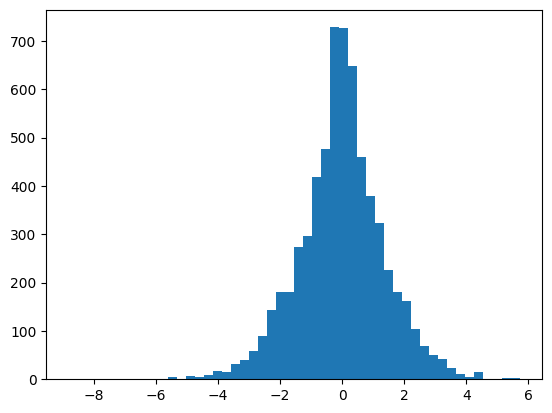

In [11]:
plt.hist(hpreact.view(-1).tolist() , 50)

In [12]:
h.shape

torch.Size([32, 200])

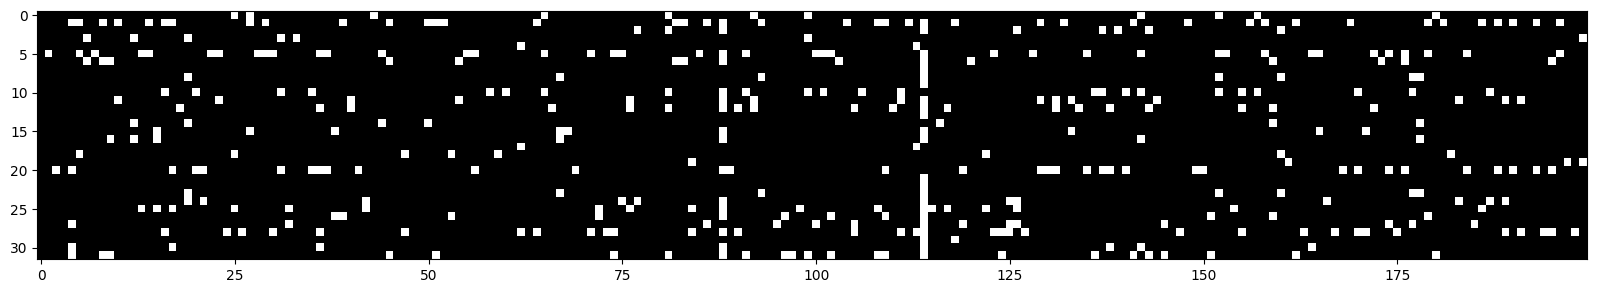

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99 , cmap='gray' , interpolation = 'nearest')

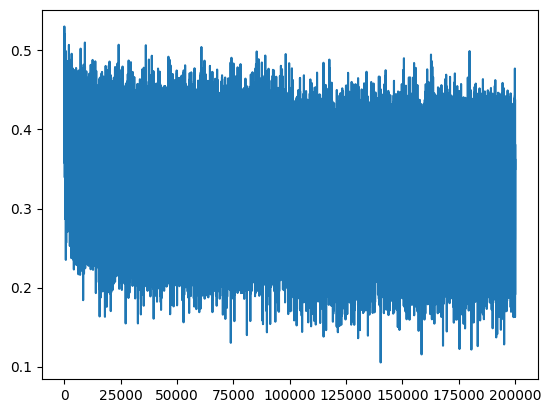

In [14]:
plt.plot(lossi)

In [15]:

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(emb_cat@W1 + b1)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')



train 3.1259379386901855
val 3.1426422595977783


In [16]:
#smaple form the model 
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1 , -1) @ W1 + b1)
        logits = h @W2 + b2
        probs = F.softmax(logits , dim=1)
        ix = torch.multinomial(probs , num_samples= 1 ,generator= g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0 :
            break
        
        
    print(''.join(itos[i] for i in out))

chapbh.
qaihs.
vahkimrharlis.
khkaaysicw.
zhick.
dheirha.
kaqeic.
ryah.
phchaihv.
khih.
gbh.
bmanvik.
qwiyah.
bockemb.
vabi.
wraelr.
dharbiggslaukwurschaeddeci.
chai.
ffrys.
kavarqh.


In [ ]:
import torch
 #linear layer
class Linear:
    def __init__(self , fan_in , fan_out , bais=True):
        #kaiming init
        self.weights = torch.randn((fan_in , fan_out) , generator = g) / fan_in**0.5
        self.bais = torch.zeros(fan_out) if bais else None
        
    def __call__(self , x):
       self.out = x @ self.weights
       if self.bais is not None:
           self.out += self.bais
       return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bais is None else [self.bais]  )        
    

#   BATCH norm 
class BatchNorm1d:
    def __init__(self , dim , eps = 1e-5 , momentum  = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        #trainable parameters (Gamma and beta)

        self.gamma = torch.ones(dim) 
        self.beta = torch.zeros(dim)
        
        #buffers running stats -- trained by moving avg --- only used during traing  to remembers the prob of the neuron -- used so that we can input a single ex
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
        
    def __call__(self, x):
        #which mean var to use
        if self.training:
            xmean = x.mean(0 , keepdim = True)
            xvar = x.var(0 , keepdim=True)
            
        else:
            xmean = self.running_mean
            xvar= self.running_var
        
            
            
            #normalise 
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
        
        #scale and shift 
        self.out = self.gamma*xhat + self.beta
        
            
            #update running stats 
            self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
            self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        


          
         

 